[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/unsupervised/customers.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Clustering for data analysis

Clustering is an important task of exploratory data analysis, and a common technique for statistical data analysis, used in many fields. In this example, we perform customer segmentation using the [K-means](https://en.wikipedia.org/wiki/K-means_clustering) algorithm. The dataset contains information about customers such as their annual income, spending score, age and gender. We will use the KMeans algorithm to cluster the customers into different groups. Then, we will perform a [clustering analysis](https://en.wikipedia.org/wiki/Cluster_analysis). The goal is to understand the different customer segments and their characteristics.

The dataset is a simplification of the [Mall Customer Segmentation Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python). It is stored in the file `data/customers.csv`. It contains the following columns:
- Annual Income (k$, integer value).
- Spending Score (1-100, integer value).
- Age (integer value).
- Gender (Male or Female).

In [11]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn  --quiet
repo='data-science-course'
module='unsupervised'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

# import the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns

from warnings import simplefilter
simplefilter(action='ignore')  # ignore all the warnings

random_state = 42

Note: you may need to restart the kernel to use updated packages.


## Dataset

Let's load the dataset, transform the `Gender` feature and show some of its values.

In [12]:
feature_names = ['Annual Income (k$)', 'Spending Score (1-100)', 'Age', 'Gender']
dataset = pd.read_csv('data/customers.csv')

# Replace 'Gender' feature: Male with 1 and Female with 0
dataset['Gender'] = dataset['Gender'].map({'Male': 1, 'Female': 0})

# Show the dataset information
print(dataset.head())
print(dataset.info())
print(dataset.describe())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender                  200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB
None
           Gender         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean     0.440000   38.850000           60.56

## Feature distribution

We show the feature distribution using the dataset.

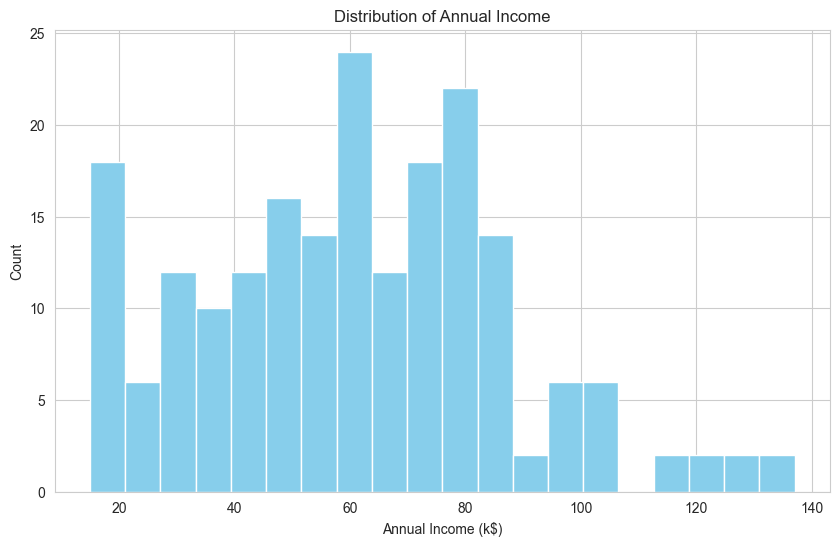

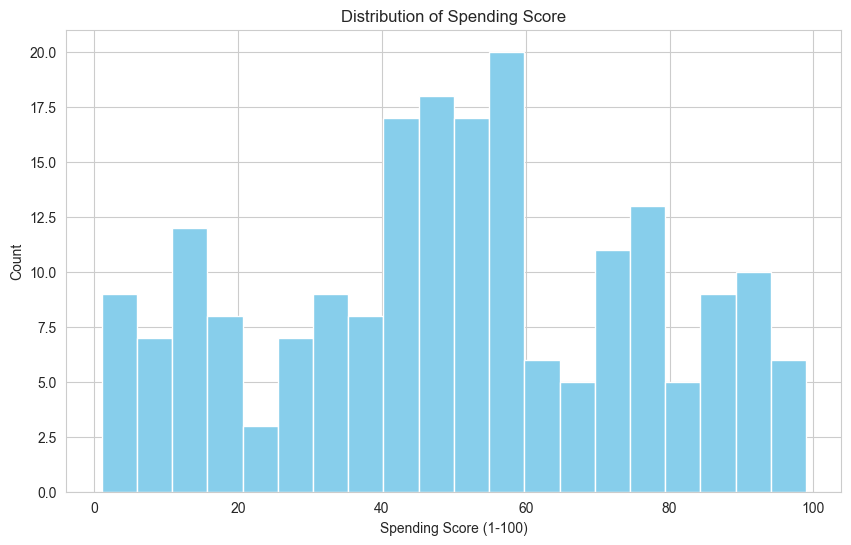

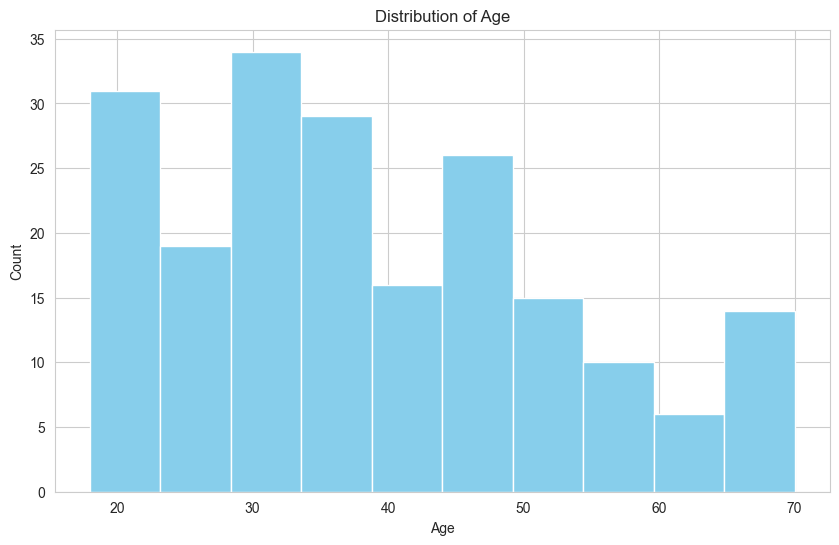

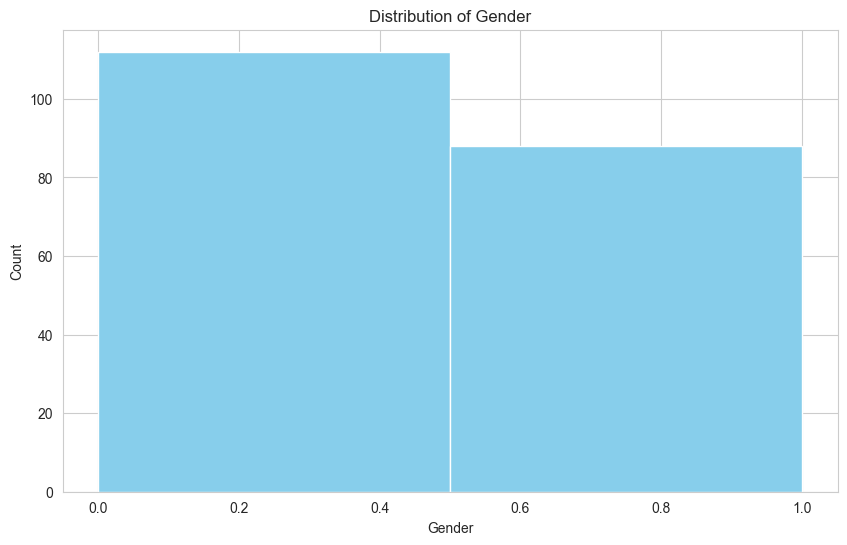

In [13]:
def show_feature_distribution(X: pd.DataFrame, feature_name: str, title: str, bins: int) -> None:
    """
    Show the distribution of a feature in the dataset
    :param X: The dataset
    :param feature_name: The feature name
    :param title: The title of the plot
    :param bins: The number of bins to categorize the data
    """
    plt.figure(figsize=(10, 6))
    plt.hist(X[feature_name], bins=bins, color='skyblue')
    plt.title(title)
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.show()


show_feature_distribution(dataset, 'Annual Income (k$)', 'Distribution of Annual Income', bins=20)
show_feature_distribution(dataset, 'Spending Score (1-100)', 'Distribution of Spending Score', bins=20)
show_feature_distribution(dataset, 'Age', 'Distribution of Age', bins=10)
show_feature_distribution(dataset, 'Gender', 'Distribution of Gender', bins=2)

## Silhouette score

We compute and visualize the silhouette scores for $k$=2 to $k$=10. 

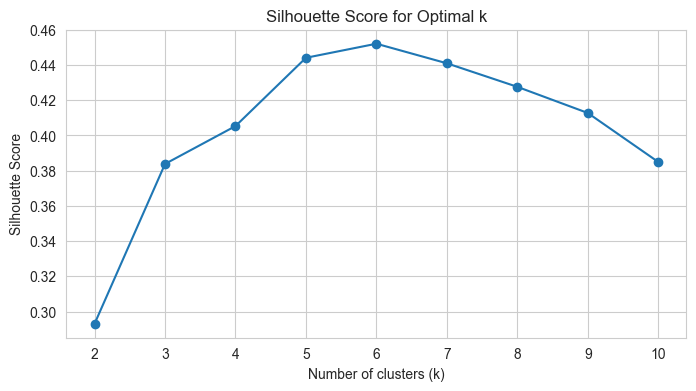

Silhouette Scores (k, score): [(2, 0.29307334005502633), (3, 0.383798873822341), (4, 0.4052954330641215), (5, 0.4440669204743008), (6, 0.45205475380756527), (7, 0.4409411333609709), (8, 0.4275788369618678), (9, 0.41273936332819244), (10, 0.384937335722974)]
Optimal number of clusters: 6.


In [14]:
def compute_silhouette_scores(X: np.array, from_k: int, to_k: int) -> np.array:
    """
    Compute the silhouette scores for different number of clusters
    :param X: the dataset
    :param from_k: the minimum number of clusters
    :param to_k: the maximum number of clusters
    :return: the silhouette scores for each number of clusters from k=from_k to k=to_k
    """
    scores = []
    for k in range(from_k, to_k + 1):
        kmeans = KMeans(n_clusters=k, init='random', n_init=50)
        clusters = kmeans.fit_predict(X)
        score = silhouette_score(X, clusters)
        scores.append(score)
    # Plot the silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(range(from_k, to_k + 1), scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()
    return scores


# Compute the optimal number of clusters using the silhouette score
silhouette_scores = compute_silhouette_scores(dataset, 2, 10)
score_per_k = list(enumerate(silhouette_scores, 2))
print("Silhouette Scores (k, score):", score_per_k)
# k is set to the maximum value
n_clusters = max(score_per_k, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {n_clusters}.")

## Clustering

We first create the clusters for the optimal number of clusters.    

In [15]:
kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=50)
clusters = kmeans.fit_predict(dataset)

Now, we visualize the distribution of the clusters in 2D after performing a dimensionality reduction using t-SNE.

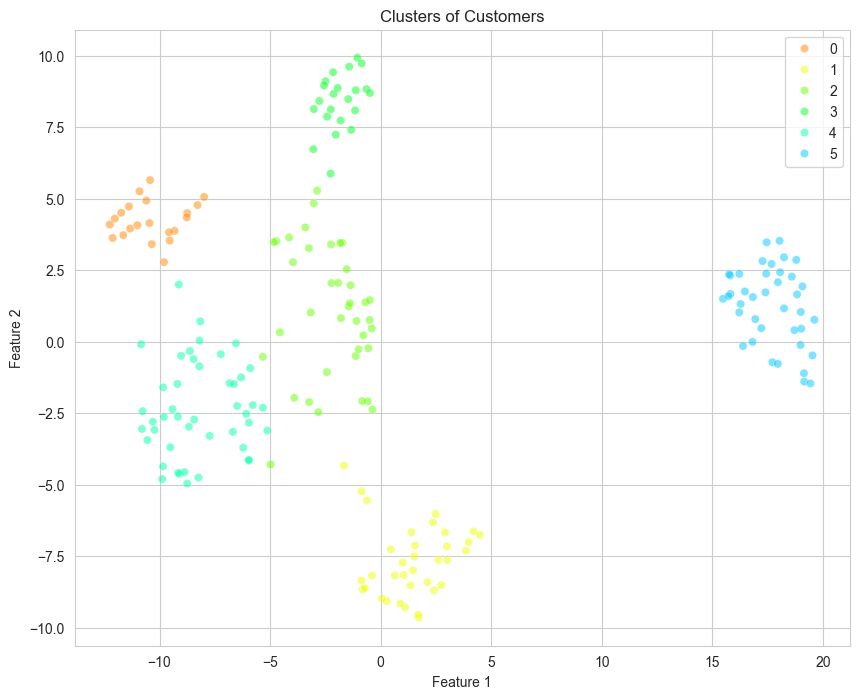

In [16]:
# Apply t-SNE to reduce the dataset to 2D
tsne = TSNE(n_components=2, random_state=random_state)
X_tsne = tsne.fit_transform(dataset)

# Let's visualize the clusters of customers to see if they are well separated
def visualize_2D(X: np.array, y: np.array, title: str) -> None:
    """
    Visualize the distribution of a dataset in 2D
    :param X: the dataset to visualize
    :param y: the labels of the dataset (clusters in this case)
    :param title: the title of the plot
    """
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("hsv", 10)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, legend='full', alpha=0.5)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

visualize_2D(X_tsne, clusters, 'Clusters of Customers')

We visualize the distribution of each feature in the dataset for each cluster.

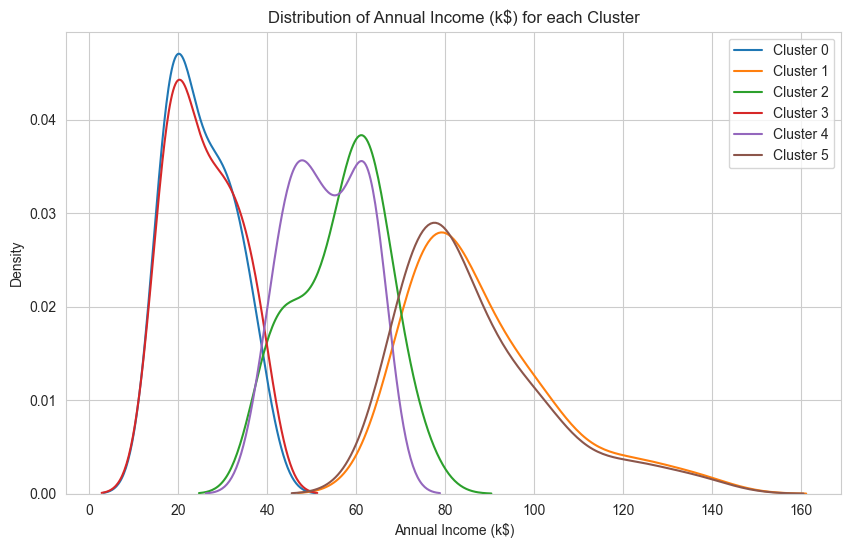

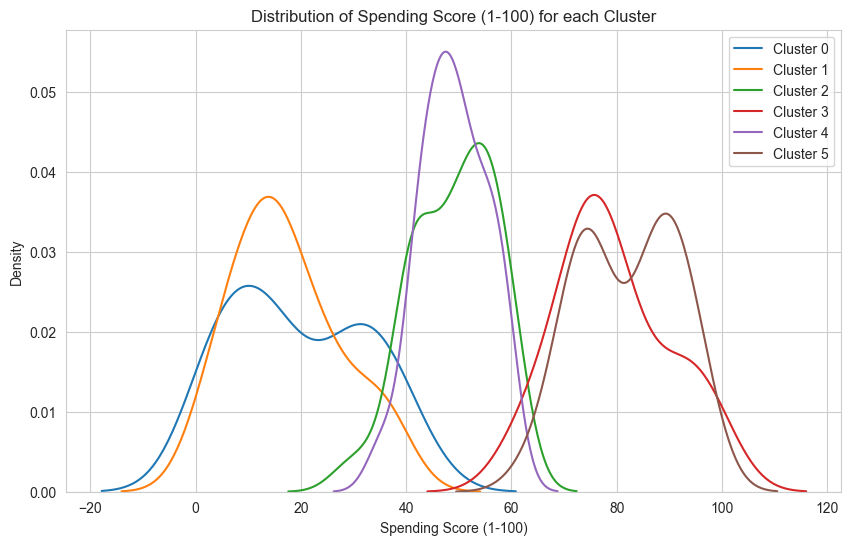

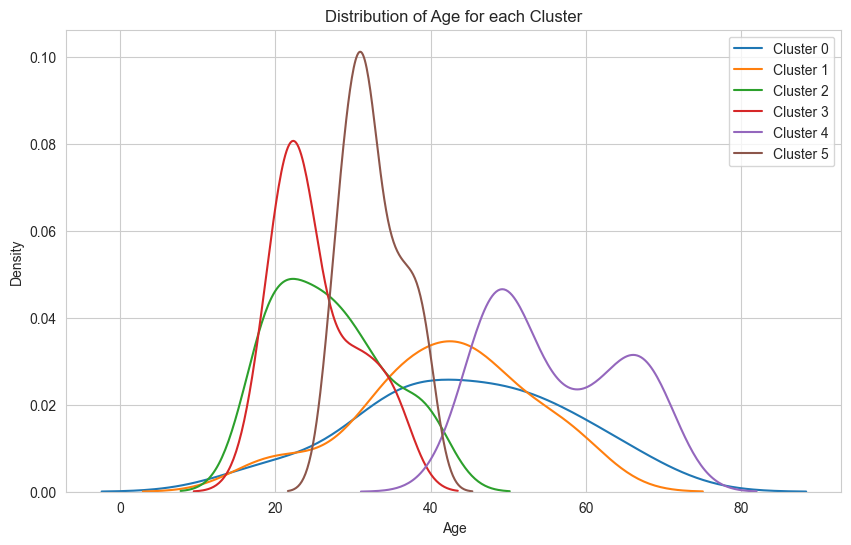

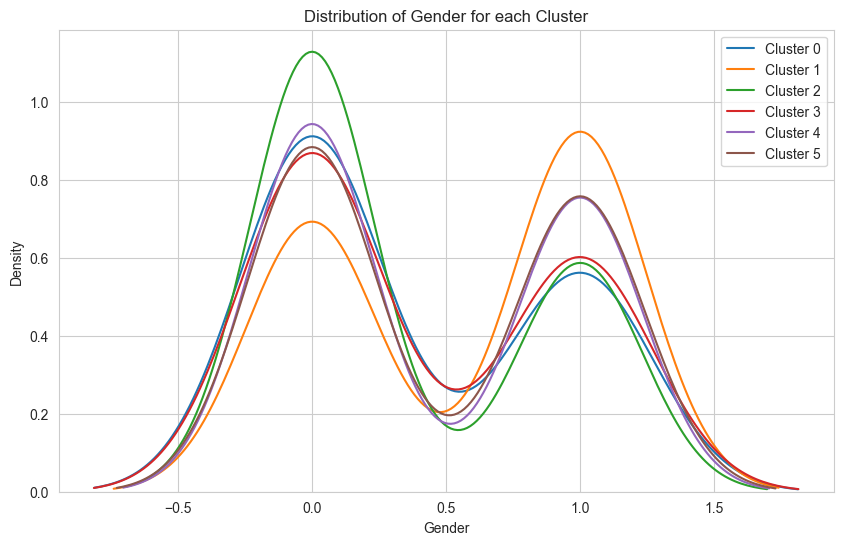

In [17]:
def show_cluster_distribution(X: pd.DataFrame, clusters: np.array, n_clusters: int, feature_name: str, bins: int) -> None:
    """
    Show the distribution of a feature for each cluster
    :param X: the dataset to visualize
    :param clusters: the clusters of the dataset (labels)
    :param n_clusters: the number of clusters
    :param feature_name: the name of the feature in X
    :param bins: the number of bins to categorize the data
    """
    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        sns.distplot(X[clusters == cluster][feature_name], bins=bins, label=f'Cluster {cluster}', hist=False)
    plt.title(f'Distribution of {feature_name} for each Cluster')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


show_cluster_distribution(dataset, clusters, n_clusters, 'Annual Income (k$)', bins=20)
show_cluster_distribution(dataset, clusters, n_clusters, 'Spending Score (1-100)', bins=20)
show_cluster_distribution(dataset, clusters, n_clusters, 'Age', bins=10)
show_cluster_distribution(dataset, clusters, n_clusters, 'Gender', bins=2)

After the visualization, we show the statistics of each feature for each cluster.

In [18]:
for cluster in range(n_clusters):
    print(f'Cluster {cluster}:')
    print(dataset[clusters == cluster].describe())

Cluster 0:
          Gender        Age  Annual Income (k$)  Spending Score (1-100)
count  21.000000  21.000000           21.000000               21.000000
mean    0.380952  44.142857           25.142857               19.523810
std     0.497613  13.089254            7.226934               12.769569
min     0.000000  19.000000           15.000000                3.000000
25%     0.000000  35.000000           19.000000                6.000000
50%     0.000000  45.000000           24.000000               15.000000
75%     1.000000  53.000000           30.000000               31.000000
max     1.000000  67.000000           39.000000               40.000000
Cluster 1:
          Gender        Age  Annual Income (k$)  Spending Score (1-100)
count  35.000000  35.000000           35.000000               35.000000
mean    0.571429  41.685714           88.228571               17.285714
std     0.502096  10.897305           16.367266               10.211215
min     0.000000  19.000000           71.0

## ✨ Activity ✨

This notebook shows you important information about the customers dataset using a clustering algorithm. Now, you must perform customer segmentation. To that aim, document the profile of customers for each cluster. Having a better understanding of the customers segments, a company could make better and more informed decisions. Cluster analysis is a powerful took in Data Science.

### Answers

- Cluster 0. *Write the customer profile for this cluster here*.
- Cluster 1. *Write the customer profile for this cluster here*.
- Cluster 2. *Write the customer profile for this cluster here*.
- Cluster 3. *Write the customer profile for this cluster here*.
- Cluster 4. *Write the customer profile for this cluster here*.
- Cluster 5. *Write the customer profile for this cluster here*.